In [1]:
# if you don't have any of these packages and you are using conda: type "conda install package" in terminal
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, log_loss
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import TruncatedSVD, PCA
#import scipy.sparse
from scipy import sparse as sp

#For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# For baseline 
import keras 
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LeakyReLU

# For graph
import networkx as nx
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

Using TensorFlow backend.


# Data understanding

## Collect initial data 

**Task: Collect initial data**\
Acquire within the project the data (or access to the data) listed in the
project resources. This initial collection includes data loading if necessary
for data understanding. 

**Output: Initial data collection report**\
List 
* the **dataset** (or datasets) acquired 
* together with their **locations** within the project
* the **methods** used to acquire them
* and any **problems** encountered. 

In [2]:
file = 'training_sample.tsv'

column_names = ["text_tokens", 
                "hashtags", 
                "tweet_id", 
                "present_media", 
                "present_links", 
                "present_domains",
                "tweet_type", 
                "language", 
                "tweet_timestamp", 
                "engaged_with_user_id", 
                "engaged_with_user_follower_count",
                "engaged_with_user_following_count", 
                "engaged_with_user_is_verified", 
                "engaged_with_user_account_creation",
                "engaging_user_id", 
                "engaging_user_follower_count", 
                "engaging_user_following_count", 
                "engaging_user_is_verified",
                "engaging_user_account_creation", 
                "engaged_follows_engaging", 
                "reply_timestamp", "retweet_timestamp",
                "retweet_with_comment_timestamp", 
                "like_timestamp"]

df = pd.read_csv(file, header=None, names=column_names, delimiter='\x01')

## Describe data 

**Task: Describe data**\
Examine the “gross” or “surface” properties of the acquired data and
report on the results.

**Output: Data description report**\
Describe the data wich has been acquired, including: 
* the **format** of the data
* the **quantity** of data, for example number of records and fields in each table,
* the **identities** of the fields and any other surface features of the data which have been discovered. 

Does the data acquired satisfy the relevant requirements?

| Feature category    | Feature name                 | Feature dtype | Feature description                                                                           |
|---------------------|------------------------------|---------------|-----------------------------------------------------------------------------------------------|
|       | text_tokens                  |        |                              
| User features       | userId                       | string        | User identifier                                                                               |
| User features       | follower count               | int           | Number of followers of the user                                                               |
| User features       | following count              | int           | Number of accounts this user is following                                                     |
| User features       | is verified                  | bool          | Is the account verified?                                                                      |
| User features       | account creation             | timestamp     | in ms int Unix timestamp (in seconds) of the creation time of the account                     |
| Tweet features      | tweetId                      | string        | Tweet identifier                                                                              |
| Tweet features      | presentMedia                 | list[string]  | Tab-separated list of media types;  media type can be in (Photo, Video, Gif)                  |
| Tweet features      | presentLinks                 | list[string]  | Tab-separated list of links included in the tweet                                             |
| Tweet features      | presentDomains               | list[string]  | Tab-separated list of domains (e.g. twitter.com) included in the tweet                        |
| Tweet features      | tweetType                    | string        | Tweet type, can be either Retweet, Quote, Reply, or Toplevel                                  |
| Tweet features      | language                     | string        | Identifier corresponding to inferred language of the tweet                                    |
| Tweet features      | tweet timestamp              | int           | Unix timestamp, in seconds of the creation time of the Tweet                                  |
| Tweet features      | tweet tokens                 | list[int]     | Ordered list of Bert ids corresponding to Bert tokenization of Tweet text                     |
| Tweet features      | tweet hashtags               | list[string]  | Tab-separated list of hashtags present in the tweet                                           |
| Engagement features | reply engagement timestamp   | int           | Unix timestamp, in seconds, of the Reply engagement if one exists.                            |
| Engagement features | retweet engagement timestamp | int           | Unix timestamp, in seconds, of the Retweet engagement if one exists.                          |
| Engagement features | quote engagement timestamp   | int           | Unix timestamp, in seconds, of the Quote engagement if one exists.                            |
| Engagement features | like engagement timestamp    | int           | Unix timestamp, in seconds, of the Like engagement if one exists.                             |
| Engagement features | engageeFollowsEngager        | bool          | Does the account of the engaged tweet author follow the account that has made the engagement? |

In [3]:
pd.set_option('display.max_columns', None)
print(df.shape)
display(df.head(20))

(80425, 24)


,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN
5,101\t46242\t40751\t161\t100062\t10107\t10114\t...,NaN,4EC1C41302B820B2459337FE31859B16,NaN,BB79CD318A68247B64F0E0BE7AFD5A92,3896E26D12C903F0A00B6B1BE9A9BEA3,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581426841,959F94011E65010724E85D1B5CBAE18F,45488,6709,True,1415444172,00008C78BF1DDCC9FDCBAFFAF318A175,34,36,False,1538872824,False,NaN,NaN,NaN,NaN
6,101\t56898\t137\t10192\t11373\t10500\t131\t219...,NaN,5A943B66B4A519817AFCD1A72F9D42BF,NaN,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581289560,0062177976C63B01A6ED88EA32B16EE3,3205,1209,False,1480887745,000094A5EE8ADAC663B322D9D7E8D4F5,67,87,False,1540388888,True,NaN,NaN,NaN,NaN
7,101\t65724\t15619\t22859\t14120\t131\t120\t120...,NaN,E4EC2A529D2B45613E1BD71E7E8A33F0,Video,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581547705,3D051D82250859217FBA448B93E1957D,16385,640,True,1165379179,0000A7ECE87C3E55F4C0ECB86805DBCF,1273,271,False,1215849548,False,NaN,NaN,NaN,1.581548e+09
8,101\t100\t45031\t43804\t10121\t10146\t89387\t1...,NaN,43C1C8729853BF2C2CF58D0CFFE6F284,Photo,EF5D0A312E7A9BAEFBEA72A062E5F6CE,3183ACF54B4022B25B4157B81C174DD5,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581031483,033DB4138030ED8CF94BF33DEBB0CB39,3126043,105891,True,1235854449,0000FF30C15DDAFB6BB0FE2EE275CD6B,38,87,False,1540785155,False,NaN,NaN,NaN,NaN
9,101\t56898\t137\t26037\t91678\t168\t15734\t737...,NaN,D1FDD2ED8C6C80C2680E9746E70F5CFE,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,1581545364,D8F0311F254EF83F42719567A94B93DA,515,498,False,1555968118,0001075D4E0F573E579B79ADDFD54712,96,105,False,1283277064,True,NaN,NaN,NaN,1.581548e+09


To get a first feeling for the data the first 20 rows are printed. It can be observed that 
* some columns seem to have a lot of NaN values. 
* Text tokens are tab-separated. 
* *Hashtags*, *present_links*, *present_domains*, *language* and *present_media* are hex-encoded and not human-readable
* timestamp-fields are ints and should be encoded to a readable format.

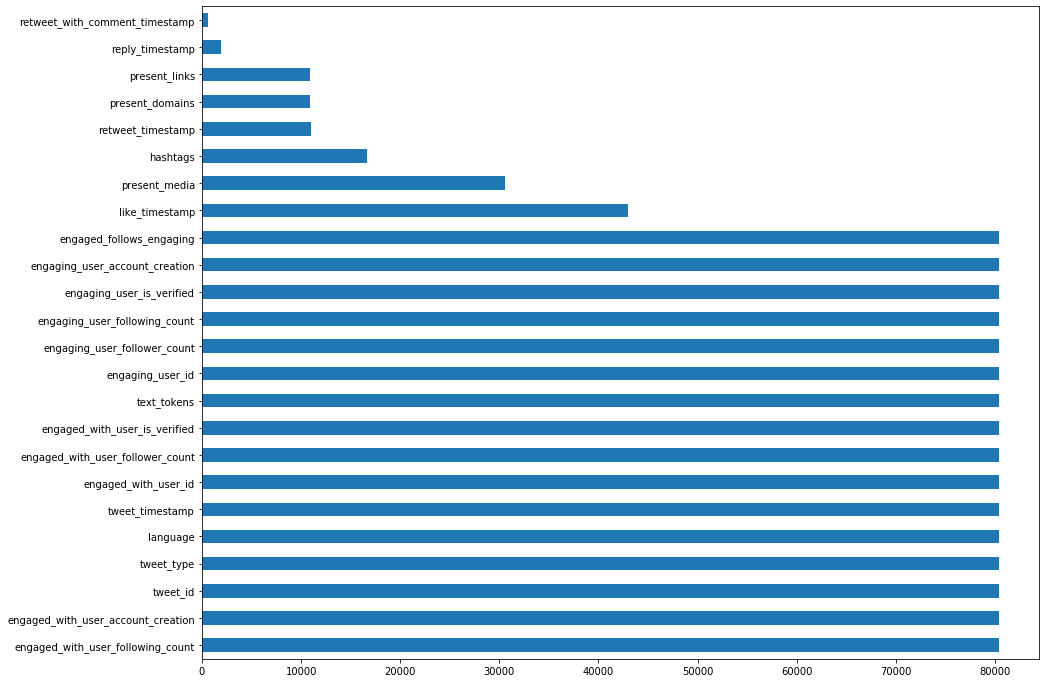

In [4]:
p_count = df.count() # to see missing values

fig, ax = plt.subplots(figsize=(15,12))
p_count.sort_values(ascending=False).plot.barh()

## Explore data 


**Task: Explore data**\
This task tackles the data mining questions, which can be addressed
using querying, visualization and reporting. These include: 
* **distribution of key attributes**, for example the target attribute of a prediction task
* **relations** between pairs or small numbers of attributes
* results of **simple aggregations**
* properties of **significant sub-populations**
* **simple statistical analyses**. These analyses may address directly the data mining goals. they may also contribute to or refine the data description, quality reports, feed into the transformation and other data preparation needed for further analysis.


**Output: Data exploration report**\
Describe results of this task including 
* **first findings** or **initial hypothesis** and their **impact** on the remainder of the project. 
* If appropriate, include **graphs and plots**, which indicate data characteristics or lead to interesting **data subsets** for further examination.

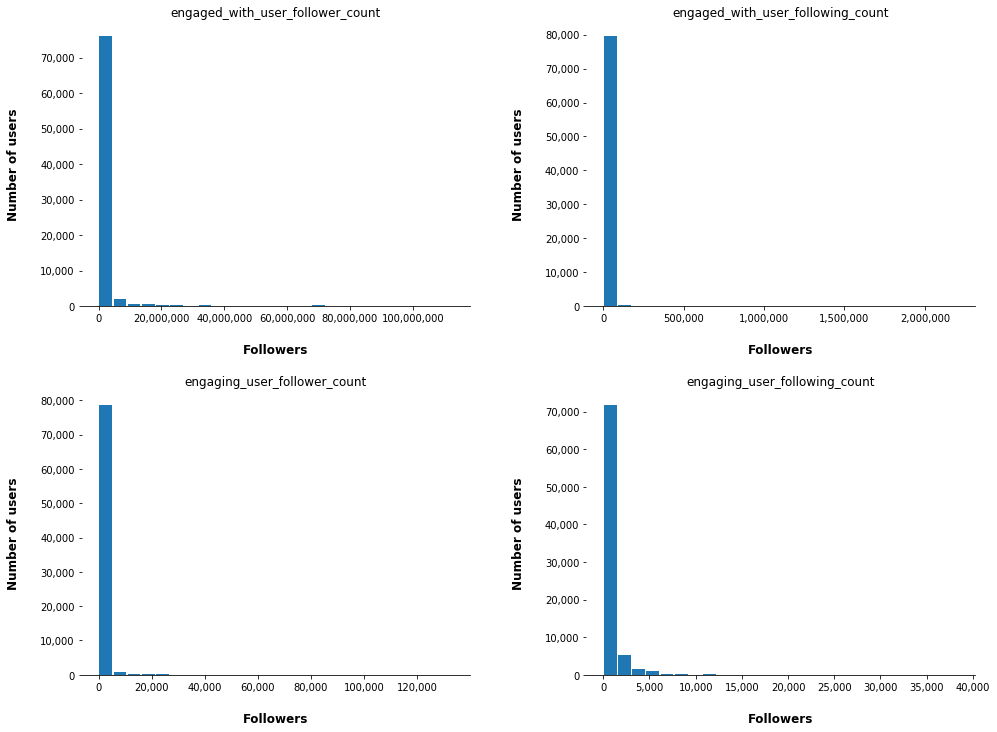

In [5]:
df_numeric = df[['engaging_user_follower_count',
                 'engaging_user_following_count',
                 'engaged_with_user_follower_count',
                 'engaged_with_user_following_count']]

fig, axes = plt.subplots(2, 2, figsize=(16,12))

df_numeric.hist(bins=25, 
                grid=False, 
                zorder=2, 
                rwidth=0.9,
                ax=axes)

for x in axes.reshape(-1): 
    #x.set_ylabel('test')
    
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Set x-axis label
    x.set_xlabel("Followers", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of users", labelpad=20, weight='bold', size=12)
    
    # Format tick labels
    x.ticklabel_format(style='plain')
    x.get_xaxis().set_major_formatter(tck.FuncFormatter(lambda x, p: format(int(x), ',')))
    x.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda x, p: format(int(x), ',')))


Powerlaw distribution. Needs to be transformed using a powertransformation to have a gaussian-like distribution.

In [6]:
df.describe()

,tweet_timestamp,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_account_creation,engaging_user_follower_count,engaging_user_following_count,engaging_user_account_creation,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
count,8.042500e+04,8.042500e+04,8.042500e+04,8.042500e+04,80425.000000,80425.000000,8.042500e+04,1.910000e+03,1.102900e+04,5.820000e+02,4.297300e+04
mean,1.581249e+09,1.342837e+06,5.441054e+03,1.392962e+09,752.948287,726.267777,1.453984e+09,1.581267e+09,1.581256e+09,1.581271e+09,1.581260e+09
std,1.715011e+05,6.690344e+06,4.264804e+04,1.159592e+08,3250.923849,1364.449826,1.005375e+08,1.712984e+05,1.710209e+05,1.715217e+05,1.684384e+05
min,1.580947e+09,1.000000e+00,0.000000e+00,1.151527e+09,0.000000,1.000000,1.172243e+09,1.580948e+09,1.580948e+09,1.580950e+09,1.580947e+09
25%,1.581106e+09,1.431000e+03,2.100000e+02,1.287243e+09,51.000000,150.000000,1.377998e+09,1.581118e+09,1.581114e+09,1.581132e+09,1.581119e+09
50%,1.581251e+09,1.647400e+04,5.860000e+02,1.390739e+09,179.000000,335.000000,1.481288e+09,1.581273e+09,1.581258e+09,1.581268e+09,1.581260e+09
75%,1.581395e+09,2.165300e+05,1.622000e+03,1.502603e+09,535.000000,736.000000,1.543003e+09,1.581416e+09,1.581405e+09,1.581426e+09,1.581405e+09
max,1.581552e+09,1.127870e+08,2.203579e+06,1.578881e+09,133431.000000,38346.000000,1.578950e+09,1.581552e+09,1.581552e+09,1.581552e+09,1.581552e+09


In [7]:
# boxplot of numeric variables
# qq-plot for numeric variables
# check for duplicate rows

## Verify data quality

**Task: Verify data quality**\
Examine the quality of the data, addressing questions such as: 
* is the data **complete** (does it cover all the cases required)? 
* Is it correct or does it contain **errors** and if there are errors **how common** are they?
* Are there **missing values** in the data? If so how are they represented, where do they occur and how common are they?


**Output: Data quality report**\
List the results of the data quality verification; if quality problems
exist, list possible solutions. Solutions to data quality problems
generally depend heavily on both data and business knowledge.

In [8]:
display(df)

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80420,101\t56898\t137\t14796\t13711\t17617\t10161\t1...,FC7321735734C2FC8A3CAE30D266CD71,533F80610C8C2F4345517986B5BB58E5,NaN,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581212842,0BCA6643D664442CA7901690F5843C1A,1432450,1869,True,1220061361,06209A39A94A7AF33B253C1EFA2D52E5,32,443,False,1393279525,False,NaN,NaN,NaN,NaN
80421,101\t56898\t137\t11885\t11273\t40154\t10206\t1...,0FE0A5F06FA20E3C2CDE7F65ACA0046C,DAC3216BB2DC4747BB2CCBA6D253A308,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,1581533061,F44A5E2FD8B6A2ACF0A1B97D57ED3C92,29193,1434,False,1251330211,0620C4B9A7E8153DFD1ECEE5FE257F9C,54,755,False,1275826974,False,NaN,NaN,NaN,NaN
80422,101\t22800\t10531\t10124\t28780\t104939\t10230...,NaN,5F9EFD38F96180EAB6BAA74481C0E6FE,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581119848,95CD94FE6760E0A5C8A183D821B8460A,96,242,False,1559761254,062154E2ED505B1DA7A9883921E42838,31,65,False,1543720066,True,NaN,NaN,NaN,1.581122e+09
80423,101\t18249\t112\t187\t169\t16745\t26133\t117\t...,NaN,8CB10325EAAD5E121E686EF222B8598C,Photo,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581052325,9DF1155503CCA735A24A0B61E0445EF7,3134,5000,False,1452619872,0621E5EBF6FB229F57303B1FB6CF7B3A,7,100,False,1395188402,False,NaN,NaN,NaN,NaN


**Completeness**\
The dataset provided by twitter is sparse but the sparseness is justified and NaN values are not considered as missing due to technical errors but due to the nature of social networks where hashtags, media and links are not always part of a message (tweet).

**Possible errors**\
Why do some users have the exactly same timestamp for two types of engagements (e.g. row_id 80424)?\

**Missing values** (only unjustified ones):\
so far none


# Data Preparation

## Select data

**Task: Select data**\
Decide on the data to be used for analysis. Criteria include relevance
to the data mining goals, quality and technical constraints such as
limits on data volume or data types. Note that data selection covers
selection of attributes (columns) as well as selection of records (rows)
in a table.

**Output: Rationale for inclusion/exclusion**\
List the data to be included/excluded and the reasons for these decisions.

## Clean data

**Task: Clean data**\
Raise the data quality to the level required by the selected analysis
techniques. This may involve selection of clean subsets of the data, the
insertion of suitable defaults or more ambitious techniques such as the
estimation of missing data by modeling.


**Output: Data cleaning report**\
Describe what decisions and actions were taken to address the data
quality problems reported during the verify data quality task of the
data understanding phase. Transformations of the data for cleaning
purposes and the possible impact on the analysis results should be
considered.

## Construct data

**Task: Construct data**\
This task includes constructive data preparation operations such as the
production of derived attributes, entire new records or transformed
values for existing attributes.


**Outputs: Derived attributes**\
Derived attributes are new attributes that are constructed from one or more
existing attributes in the same record. Examples: area = length * width.
Generated records
Describe the creation of completely new records. Example: create
records for customers who made no purchase during the past year.
There was no reason to have such records in the raw data, but for
modeling purposes it might make sense to explicitly represent the fact
that certain customers made zero purchases.

### Enhance dataset with derived columns

## Independent variables
The following new variables were defined in the dataframe:

| Name | Type | Description |
| --- | --- | --- |
| has_media | bool | Indicates that is there any media type related to the tweet or not? (should be omitted later, it was just a helper for further extraction) |
| cnt_Photo | Integer | number of photo media in the tweet |
| cnt_Video | Integer | number of video media in the tweet|
| cnt_GIF | Integer | number of GIF media in the tweet |
| cnt_Other_media | Integer | (maybe it's impossible) if there is an unknown media type, it will be counted |
| cnt_Hashtags | Integer | Count the number of hashtags in each tweet |
| cnt_Domains | Integer | Count the number of domains in each tweet |
| cnt_Links | Integer | Count the number of links in each tweet |
| cnt_Words_In_Tweet | Integer | Count the number of words in the tweet |


## Labels
| Name | Type | Description |
| --- | --- | --- |
| is_like | bool | indicates that was there a like by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| is_reply | bool | indicates that was there a reply by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| is_retweet | bool | indicates that was there a retweet by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| is_retweet_with_comment | bool | indicates that was there a retweet with comment by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| is_retweet_with_comment | bool | indicates that was there a retweet with comment by the engaging user on the tweet (decided on that is there timestamp exists or not) |

## Further Ideas to variable extraction:
Edit the following table if you want to propose new attribute

| Name | Type | Description |
| --- | --- | --- |
| daytime | category | converts tweet_timestamp into part of the day categorical variable |
| engaging_user_degreec | number | degree centrality value of engaging_user |
| engaged_with_user_degreec | number | degree centrality value of engaged_with_user |

In [9]:
df['present_media'].unique

<bound method Series.unique of 0        Video
1          NaN
2          NaN
3        Video
4          NaN
         ...  
80420      NaN
80421      NaN
80422      NaN
80423    Photo
80424      NaN
Name: present_media, Length: 80425, dtype: object>

Is there any media in the cell?

In [10]:
df['has_media'] = df['present_media'].notna()

In [11]:
df[['has_media','present_media']]

,has_media,present_media
0,True,Video
1,False,NaN
2,False,NaN
3,True,Video
4,False,NaN
...,...,...
80420,False,NaN
80421,False,NaN
80422,False,NaN
80423,True,Photo


## Count the different media types for every tweet

In [12]:
photoCnt = []
videoCnt = []
gifCnt = []
other = []
for d,b in zip(df['present_media'],  df['has_media']):
    if b is True:
        pht = d.count("Photo")
        video = d.count("Video")
        gif  = d.count("GIF")
        photoCnt.append(pht)
        videoCnt.append(video)
        gifCnt.append(gif)
        
        if len(str(d).split()) != int(pht + video + gif):
             other.append(len(str(d).split()) - int(pht + video + gif))
        else:
             other.append(0)
    else:
        photoCnt.append(0)
        videoCnt.append(0)
        gifCnt.append(0)
        other.append(0)                       

In [13]:
df['cnt_Photo'] = photoCnt
df['cnt_Video'] = videoCnt
df['cnt_GIF'] = gifCnt
df['cnt_Other_Media'] = other

In [14]:
df[['present_media','cnt_Photo', 'cnt_Video', 'cnt_GIF', 'cnt_Other_Media']].head(5)

,present_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media
0,Video,0,1,0,0
1,NaN,0,0,0,0
2,NaN,0,0,0,0
3,Video,0,1,0,0
4,NaN,0,0,0,0


## Count the number of hashtags in each tweet

In [15]:
df['cnt_Hashtags'] = df.apply(lambda x : len(str(x['hashtags']).split()) if str(x['hashtags']) != "nan" else 0,axis=1)

## Count the number of links in each tweet

In [16]:
df['cnt_Links'] = df.apply(lambda x : len(str(x['present_links']).split()) if str(x['present_links']) != "nan" else 0,axis=1)

## Count the number of domains in each tweet

In [17]:
df['cnt_Domains'] = df.apply(lambda x : len(str(x['present_domains']).split()) if str(x['present_domains']) != "nan" else 0,axis=1)

## Count the number of words in the tweet

It is also worth to mention, that there are separators in the text with ID [101], [131], [102] (but at least 2 separator in each tweet)

In [18]:
df['cnt_Words_In_Tweet'] = df.apply(lambda x : len(str(x['text_tokens']).split()) if str(x['text_tokens']) != "nan" else 0,axis=1)

Average number of words

In [19]:
np.mean(df['cnt_Words_In_Tweet'])

48.516990985390116

Minimum number of words

In [20]:
np.min(df['cnt_Words_In_Tweet'])

2

Max number of words

In [21]:
np.max(df['cnt_Words_In_Tweet'])

255

df[["text_tokens",'no_Words_In_Tweet', 'hashtags','no_Hashtags', 'present_links', 'no_Links', 'present_domains', 'no_Domains']].head(3)

In [22]:
dfCountToPlot = df[['cnt_Words_In_Tweet', 'cnt_Hashtags',  'cnt_Links', 'cnt_Domains']]

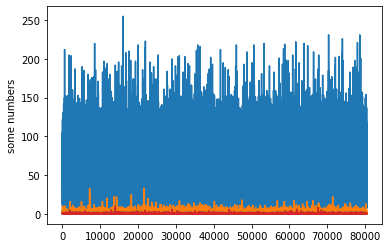

In [23]:
plt.plot(dfCountToPlot)
plt.ylabel('some numbers')
plt.show()

In [24]:
dfCountToPlot.corr()

,cnt_Words_In_Tweet,cnt_Hashtags,cnt_Links,cnt_Domains
cnt_Words_In_Tweet,1.000000,0.328732,0.260528,0.260528
cnt_Hashtags,0.328732,1.000000,0.131472,0.131472
cnt_Links,0.260528,0.131472,1.000000,1.000000
cnt_Domains,0.260528,0.131472,1.000000,1.000000


In [25]:
df.corr()

,tweet_timestamp,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet
tweet_timestamp,1.000000,-0.010026,0.001386,0.022548,-0.017434,0.008349,0.005332,-0.003852,-0.004742,-0.004963,0.987269,0.989816,0.994646,0.987787,-0.011047,-0.011848,0.000301,0.006396,NaN,0.005814,0.016274,0.016274,0.002188
engaged_with_user_follower_count,-0.010026,1.000000,0.093223,0.308682,-0.235955,-0.024451,-0.035561,-0.005888,-0.013685,-0.143131,-0.016593,-0.000320,-0.072185,-0.007674,0.030339,-0.008244,0.051805,-0.010838,NaN,-0.001936,0.054918,0.054918,-0.001103
engaged_with_user_following_count,0.001386,0.093223,1.000000,0.058721,-0.069561,0.010356,0.032920,-0.000062,-0.016997,0.044668,-0.047723,0.012734,0.005585,0.007338,-0.026800,-0.022214,-0.008841,-0.005961,NaN,-0.007913,0.025820,0.025820,-0.010673
engaged_with_user_is_verified,0.022548,0.308682,0.058721,1.000000,-0.500664,-0.036397,-0.059831,0.030250,-0.115588,-0.417194,0.000956,0.022465,-0.015710,0.025008,0.020849,-0.032135,0.041479,-0.002380,NaN,0.071774,0.217037,0.217037,0.077791
engaged_with_user_account_creation,-0.017434,-0.235955,-0.069561,-0.500664,1.000000,0.005309,0.011675,-0.042345,0.282018,0.305142,-0.020849,-0.009120,-0.006345,-0.017351,0.040212,0.064025,0.013990,-0.001565,NaN,0.017783,-0.178890,-0.178890,-0.028455
engaging_user_follower_count,0.008349,-0.024451,0.010356,-0.036397,0.005309,1.000000,0.423069,0.183068,-0.115888,0.132183,0.057199,0.021251,0.082425,0.009687,-0.020403,-0.008903,-0.010653,-0.003417,NaN,-0.017025,-0.017831,-0.017831,-0.011829
engaging_user_following_count,0.005332,-0.035561,0.032920,-0.059831,0.011675,0.423069,1.000000,0.044631,-0.154658,0.118402,-0.005847,0.018180,-0.006054,0.001187,-0.025263,-0.017410,-0.004377,-0.006125,NaN,-0.023859,-0.021941,-0.021941,-0.001430
engaging_user_is_verified,-0.003852,-0.005888,-0.000062,0.030250,-0.042345,0.183068,0.044631,1.000000,-0.085068,0.021150,-0.014661,-0.007048,-0.035833,-0.003123,-0.009730,-0.010408,-0.002631,0.004247,NaN,-0.004713,0.001839,0.001839,-0.009680
engaging_user_account_creation,-0.004742,-0.013685,-0.016997,-0.115588,0.282018,-0.115888,-0.154658,-0.085068,1.000000,0.030990,-0.029162,0.003720,0.063001,0.000167,0.037283,0.039349,0.022333,-0.010112,NaN,0.035642,-0.052760,-0.052760,0.005266
engaged_follows_engaging,-0.004963,-0.143131,0.044668,-0.417194,0.305142,0.132183,0.118402,0.021150,0.030990,1.000000,0.027569,-0.016520,0.050799,-0.011219,-0.086642,-0.032254,-0.049564,-0.016914,NaN,-0.074455,-0.152791,-0.152791,-0.104326


## Encode what kind of interactions was the engaging user did with the tweet
Decided on timestamp: if there is timestamp, the interaction has happened (1), else no (0)
- Is_reply 
- Is_retweet
- is _retweet_with_comment
- Is_like

In [26]:
df['is_reply'] = df['reply_timestamp'].notna()
df['is_like'] = df['like_timestamp'].notna()
df['is_retweet_with_comment'] = df['retweet_with_comment_timestamp'].notna()
df['is_retweet'] = df['retweet_timestamp'].notna()

In [27]:
df[['reply_timestamp','is_reply', 'like_timestamp', 'is_like', 'retweet_with_comment_timestamp', 'is_retweet_with_comment','retweet_timestamp' ,'is_retweet']].head(20)

,reply_timestamp,is_reply,like_timestamp,is_like,retweet_with_comment_timestamp,is_retweet_with_comment,retweet_timestamp,is_retweet
0,NaN,False,NaN,False,NaN,False,NaN,False
1,NaN,False,NaN,False,NaN,False,NaN,False
2,NaN,False,NaN,False,NaN,False,NaN,False
3,NaN,False,1.581305e+09,True,NaN,False,NaN,False
4,NaN,False,NaN,False,NaN,False,NaN,False
5,NaN,False,NaN,False,NaN,False,NaN,False
6,NaN,False,NaN,False,NaN,False,NaN,False
7,NaN,False,1.581548e+09,True,NaN,False,NaN,False
8,NaN,False,NaN,False,NaN,False,NaN,False
9,NaN,False,1.581548e+09,True,NaN,False,NaN,False


In [28]:
display(df.head())

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,is_reply,is_like,is_retweet_with_comment,is_retweet
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN,True,0,1,0,0,0,0,0,31,False,False,False,False
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,1,34,False,False,False,False
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN,False,0,0,0,0,1,1,1,89,False,False,False,False
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09,True,0,1,0,0,0,0,0,22,False,True,False,False
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN,False,0,0,0,0,0,0,0,31,False,False,False,False


## Converting tweet timestamp into categorical (morning, afternoon, evening, night) variable 

In [29]:
from datetime import datetime, timezone
def get_part_of_day(timestamp):
    t=datetime.fromtimestamp(timestamp)
    hour=int(t.strftime('%H'))
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
)
df['daytime'] = df.apply(lambda x: get_part_of_day(x['tweet_timestamp']), axis=1)
df.head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,is_reply,is_like,is_retweet_with_comment,is_retweet,daytime
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN,True,0,1,0,0,0,0,0,31,False,False,False,False,night
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,1,34,False,False,False,False,morning
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN,False,0,0,0,0,1,1,1,89,False,False,False,False,afternoon
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09,True,0,1,0,0,0,0,0,22,False,True,False,False,afternoon
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN,False,0,0,0,0,0,0,0,31,False,False,False,False,morning


Visualizing the distribution of tweet times

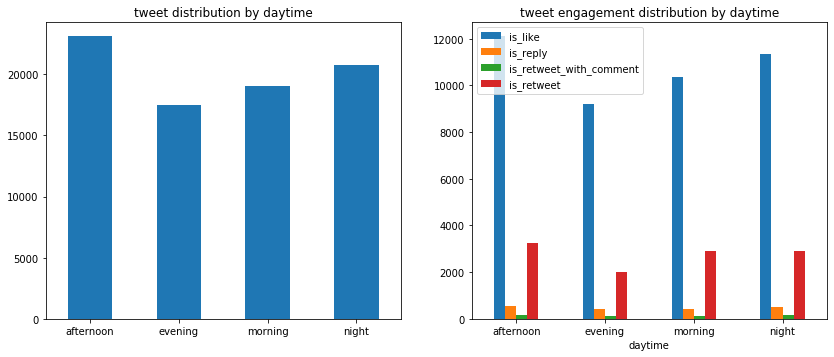

In [30]:
plt.figure()
ax1 = plt.subplot(221)
df['daytime'].value_counts().sort_index().plot(kind='bar',rot=0,ax=ax1,figsize=(14, 12),title='tweet distribution by daytime')
ax2 = plt.subplot(222)
df.groupby('daytime')['is_like','is_reply','is_retweet_with_comment','is_retweet'].sum().sort_index().plot.bar(rot=0,ax=ax2,figsize=(14, 12),title='tweet engagement distribution by daytime')

Mapping strings with numbers for modeling (it is commented out yet, but might be needed)

In [31]:
"""
df['daytime'] = df['daytime'].map({
    'morning':1, 'afternoon':2, 'evening':3, 'night':4
})
df.head()
"""

"\ndf['daytime'] = df['daytime'].map({\n    'morning':1, 'afternoon':2, 'evening':3, 'night':4\n})\ndf.head()\n"

## Vizualizing the network and adding centrality measures as additional user features to the dataframe

### T4. Extract the Social Network
* Twitter Social Network is directional (follower – following) 
* parse the `engaged_follows_engaging` field: each example gives you an edge
* Create the adjacency matrix representation of the social graph
* If an edge exists between two users, 0 otherwise
* how can you use this information?

In [32]:
# FROM TUWEL
unique_user_ids = df['engaging_user_id'].append(df['engaged_with_user_id']).unique()

m = len(unique_user_ids)

userId_to_userIDX = dict(zip(unique_user_ids, range(m)))
userIDX_to_userId = dict(zip(range(m), unique_user_ids))

e_df = df[df['engaged_follows_engaging']][['engaging_user_id', 'engaged_with_user_id', 'engaged_follows_engaging']]

e_df['engaging_user_idx'] = e_df['engaging_user_id'].map(userId_to_userIDX)
e_df['engaged_with_user_idx'] = e_df['engaged_with_user_id'].map(userId_to_userIDX)

e_df.sort_values(by=['engaging_user_idx'], inplace = True)
e_df.drop_duplicates(inplace = True)
e_df.reset_index(drop = True, inplace = True)

display(e_df.head())

,engaging_user_id,engaged_with_user_id,engaged_follows_engaging,engaging_user_idx,engaged_with_user_idx
0,00006047187D0D18598EF12A650E1DAC,AA1F44078BF66B12F87E9E5064B9BEC6,True,1,55103
1,0000648BAA193AE4C625DDF789B57172,F1AE231029BFC328EE863FDE84883987,True,2,62418
2,00007745A6EE969F1A0F44B10DC17671,3C315728DF00E6FBF60E0542F4E5C62A,True,4,32559
3,00007745A6EE969F1A0F44B10DC17671,02FE74934CC2CEEEC4B821064FACC574,True,4,57017
4,00007745A6EE969F1A0F44B10DC17671,BF3EC3EBAF644CFAFF3627FF25EE0B27,True,4,20526


In [33]:
# get original user id for user 1127 --> '00B9BBC10BBA33C2E5B53C9BAC7C5863'
e_df[e_df['engaging_user_idx']==1127].head()

,engaging_user_id,engaged_with_user_id,engaged_follows_engaging,engaging_user_idx,engaged_with_user_idx
2657,00B9BBC10BBA33C2E5B53C9BAC7C5863,B7D85703B0DBF0BBC0189167D9B95FA1,True,1127,43516
2658,00B9BBC10BBA33C2E5B53C9BAC7C5863,A0546B8189DF8DF304D5358AE1BB8CD1,True,1127,43517
2659,00B9BBC10BBA33C2E5B53C9BAC7C5863,2849B73BB820D0E4DE14AF05EE9A83C1,True,1127,57228
2660,00B9BBC10BBA33C2E5B53C9BAC7C5863,949CCE08CFB93D30E6640BD0A0BD1363,True,1127,20794
2661,00B9BBC10BBA33C2E5B53C9BAC7C5863,C48D3C0D353943CFD556707F257AF044,True,1127,55344


In [34]:
SN = sp.csr_matrix((e_df.engaged_follows_engaging, (e_df.engaging_user_idx, e_df.engaged_with_user_idx)), shape=(m, m))
SN.shape

(65963, 65963)

Using the adjacency matrix, we can create a graph that represents the connection (following) between the users. Remember: the "engaged_follows_engaging" attribute represents whether the user who created the engaded tweet follows the user who is engaging. Then we can have a graph with 65963 nodes and 24234 edges. (For making it simple we created an undirected graph that simply represents the connection between two user however a directed graph would be also adequate that also encodes the direction of the connection)

In [35]:
G = nx.from_scipy_sparse_matrix(SN,create_using=nx.Graph())
print("{} nodes, {} edges".format(len(G), nx.number_of_edges(G)))

65963 nodes, 24234 edges


### Calculating centralities
Having the graph ready, we analyzed the degree centrality measures of the nodes:
*  `degree centrality`: defined as the number of links that a node has 

In [36]:
dc = dict((G).degree())
c_df=pd.DataFrame(sorted(dc.items(), key=lambda x: x[1], reverse=True),columns=['id', 'dc'])

# map back ids to user ids from the original dataframe
c_df['id']=c_df['id'].map(userIDX_to_userId)

In [37]:
# inspect user '00B9BBC10BBA33C2E5B53C9BAC7C5863'
c_df[c_df['id']=='00B9BBC10BBA33C2E5B53C9BAC7C5863']

,id,dc
0,00B9BBC10BBA33C2E5B53C9BAC7C5863,79


We add these centrality measures as additional features for the engaging and engaged with users in the dataframe

In [38]:
# create a dictionary of user ids and centrality measures to speed-up mapping with the original df
c_dict=c_df.set_index('id').T.to_dict('list')
df['engaging_user_degreec']=df['engaging_user_id'].map(c_dict).apply(lambda x: x[0])
df['engaged_with_user_degreec']=df['engaged_with_user_id'].map(c_dict).apply(lambda x: x[0])
df.head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,is_reply,is_like,is_retweet_with_comment,is_retweet,daytime,engaging_user_degreec,engaged_with_user_degreec
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN,True,0,1,0,0,0,0,0,31,False,False,False,False,night,0,0
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,1,34,False,False,False,False,morning,1,1
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN,False,0,0,0,0,1,1,1,89,False,False,False,False,afternoon,1,0
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09,True,0,1,0,0,0,0,0,22,False,True,False,False,afternoon,0,0
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN,False,0,0,0,0,0,0,0,31,False,False,False,False,morning,3,0


In [39]:
# inspect user '00B9BBC10BBA33C2E5B53C9BAC7C5863'
df[df['engaging_user_id']=='00B9BBC10BBA33C2E5B53C9BAC7C5863'].head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,is_reply,is_like,is_retweet_with_comment,is_retweet,daytime,engaging_user_degreec,engaged_with_user_degreec
1289,101\t56898\t137\t11163\t32851\t20042\t11143\t1...,NaN,47CE27C8E62BBCCEA974EB6935D7CA06,NaN,NaN,NaN,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581285198,3C27DC2CF1FEA1DCFACE48DDF6A5FB0E,11113,9397,False,1268781389,00B9BBC10BBA33C2E5B53C9BAC7C5863,1936,1444,False,1439164328,True,NaN,1.581288e+09,NaN,1.581288e+09,False,0,0,0,0,0,0,0,69,False,True,False,True,evening,79,2
1290,101\t1953\t54011\t11588\t85551\t31656\t99624\t...,NaN,51C0E95DF5D7CDDA5E6DDBCD0C3B1D73,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581001286,677DC1BD97032B4C5E1026F79F365291,4653,561,False,1557763134,00B9BBC10BBA33C2E5B53C9BAC7C5863,1936,1444,False,1439164328,False,NaN,1.581040e+09,NaN,1.581040e+09,True,1,0,0,0,0,0,0,25,False,True,False,True,afternoon,79,1
1291,101\t100\t119\t119\t2187\t4469\t1947\t22946\t1...,NaN,6D379EF4E9B793A6EAF11E28CE7F1965,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581121852,7E76ECE852C30B74117C46F6955F1AAD,41030,43231,False,1379355846,00B9BBC10BBA33C2E5B53C9BAC7C5863,1936,1444,False,1439164328,True,NaN,1.581123e+09,NaN,1.581123e+09,True,1,0,0,0,0,0,0,39,False,True,False,True,night,79,2
1292,101\t5719\t44360\t2251\t7235\t1947\t3197\t2076...,NaN,BE5FCBFB09C1B1D6D8E9D0893106CF8C,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581205156,97E8B734421FDA7C8FFCCB6FF00DF183,13327,12411,False,1519140701,00B9BBC10BBA33C2E5B53C9BAC7C5863,1936,1444,False,1439164328,True,NaN,1.581207e+09,NaN,1.581207e+09,True,1,0,0,0,0,0,0,56,False,True,False,True,night,79,1
12046,101\t1910\t11588\t10060\t100\t10061\t108\t7524...,8646EAE416202805F8D6ADC4AC76C6DF,028073C2A2B85DD735D431971D114AF9,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581120249,99B970974E32A3FB01ED587C71B7AA76,7134,2765,False,1536642324,00B9BBC10BBA33C2E5B53C9BAC7C5863,1936,1444,False,1439164328,True,NaN,1.581124e+09,NaN,1.581124e+09,True,1,0,0,0,1,0,0,29,False,True,False,True,night,79,1


Encoding centrality measures to True or False bool variable (True means the user is important in the network, having degree centrality value greater than the median) and check their distribution grouped by engagement type.

In [44]:
display(df['engaging_user_degreec'].median())
df['is_engaging_user_degreec']=df['engaging_user_degreec']>df['engaging_user_degreec'].median()
df['is_engaged_with_user_degreec']=df['engaged_with_user_degreec']>df['engaged_with_user_degreec'].median()

2.0

We can see that the centrality of the engaging user has some impact on the probability of the engagement, since there are less not important users in the dataset, but we get higher numbers for the engagement types among the important users. 

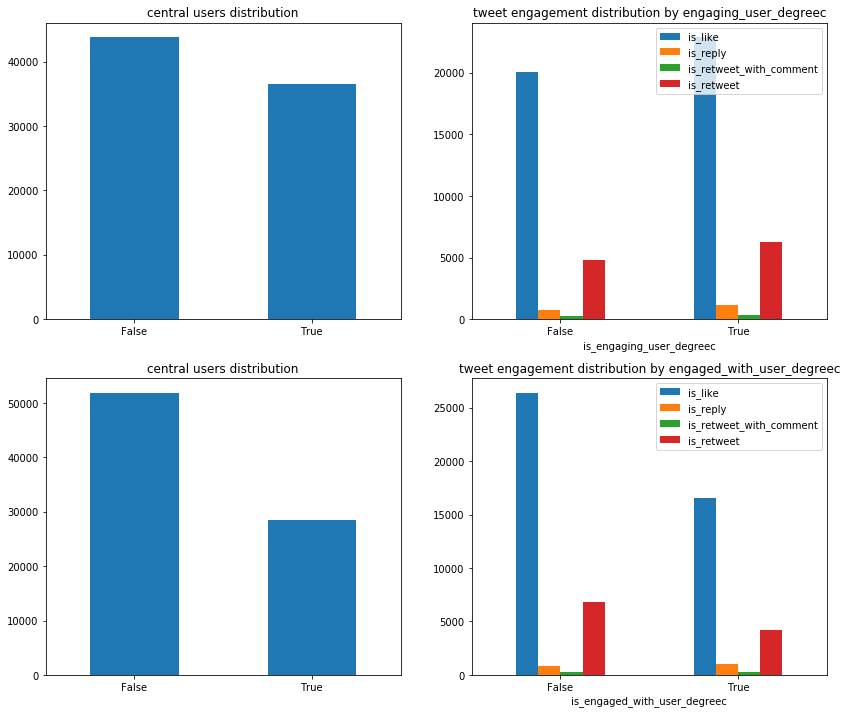

In [45]:
plt.figure()
ax1 = plt.subplot(221)
df['is_engaging_user_degreec'].value_counts().sort_index().plot(kind='bar',rot=0,ax=ax1,figsize=(14, 12),title='central users distribution')
ax2 = plt.subplot(222)
df.groupby('is_engaging_user_degreec')['is_like','is_reply','is_retweet_with_comment','is_retweet'].sum().sort_index().plot.bar(rot=0,ax=ax2,figsize=(14, 12),title='tweet engagement distribution by engaging_user_degreec')
ax3 = plt.subplot(223)
df['is_engaged_with_user_degreec'].value_counts().sort_index().plot(kind='bar',rot=0,ax=ax3,figsize=(14, 12),title='central users distribution')
ax4 = plt.subplot(224)
df.groupby('is_engaged_with_user_degreec')['is_like','is_reply','is_retweet_with_comment','is_retweet'].sum().sort_index().plot.bar(rot=0,ax=ax4,figsize=(14, 12),title='tweet engagement distribution by engaged_with_user_degreec')
plt.show()

### Network vizualization
Since the graph was too big to effectively visualize, we took the largest connected subgraph of the graph. It has 482 nodes and 484 edges that is appropiate for the vizualization.

In [196]:
SG = max(nx.connected_component_subgraphs(G), key=len)
print("{} nodes, {} edges".format(len(SG), nx.number_of_edges(SG)))

482 nodes, 484 edges


We created the vizualization of the subgraph using the ploty and networkx packages. We can see that there are some central nodes within the network which have many followers but the connection between these groups are weak.

In [197]:
pos = nx.spring_layout(SG)
for node in SG.nodes():
    SG.node[node]['pos']= pos[node]
edge_x = []
edge_y = []
for edge in SG.edges():
    x0, y0 = SG.nodes[edge[0]]['pos']
    x1, y1 = SG.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='black'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in SG.nodes():
    x, y = SG.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_text = []
for node in SG.nodes():
    node_text.append(str(node))

node_adjacencies = []
for node, adjacencies in enumerate(SG.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    
node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network graph of twitter followers<br>',
                titlefont_size=14,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
py.iplot(fig, filename='twitter_graph')

## Format data

**Task: Format data**\
Formatting transformations refer to primarily syntactic modifications
made to the data that do not change its meaning, but might be required
by the modeling tool.


**Output: Reformatted data**\
Some tools have requirements on the order of the attributes, such as
the first field being a unique identifier for each record or the last field
being the outcome field the model is to predict.
It might be important to change the order of the records in the dataset.
Perhaps the modeling tool requires that the records be sorted according
to the value of the outcome attribute. A common situation is that the
records of the dataset are initially ordered in some way but the modeling
algorithm needs them to be in a fairly random order. For example, when
using neural networks it is generally best for the records to be presented
in a random order although some tools handle this automatically without explicit user intervention

In [134]:
# Parse attributes containing tab-separated lists into lists.
df['text_tokens'] = df['text_tokens'].str.split('\t')

def to_hex_list(x):
    output = str(x).split('\t')
#     output = [int(val, 16) for val in str(x).split('\t')] 
    return output

cols_to_process = ['hashtags', 'present_media', 'present_links', 'present_domains']

for col in cols_to_process:  
    df[col] = df[col].apply(lambda x: to_hex_list(x) if isinstance(x, str)  else x)


# Transform raw timestamps into human-readable timestamps.
cols_to_process = ['tweet_timestamp', 'engaging_user_account_creation', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp']

for col in cols_to_process:  
    df[col] = df[col].apply(lambda x: pd.Timestamp(x, unit='s'))

# Modelling

## T1. Split into train, dev, test
* Sub-sample to create test, non-test datasets
* Optionally split non-test into train and dev
* e.g., to implement k-fold validation

In [135]:
# Train/Test split

from sklearn.model_selection import train_test_split
X_nontest, X_test = train_test_split(df, test_size = 0.1, random_state = 42)
X_train, X_dev = train_test_split(X_nontest, test_size = 0.1, random_state = 42)
print(X_train.shape, X_dev.shape, X_test.shape)

(65143, 37) (7239, 37) (8043, 37)


## T5. Implement a Baseline

Implement the neural network approach described in the challenge paper: https://arxiv.org/abs/2004.13715.
This Baseline will be used in the evaluation phase to compare our Naive Bayes and Multivariate Regression approaches to it.

In [136]:
numeric_cols = ['engaged_with_user_follower_count', 
                'engaged_with_user_following_count', 
                'engaged_with_user_account_creation',
                'engaging_user_follower_count', 
                'engaging_user_following_count',
                'engaging_user_account_creation',
                'tweet_timestamp',
               ]

categorical_cols = ['tweet_type', 'language', 
                    'engaged_with_user_is_verified', 'engaging_user_is_verified', 'engaged_follows_engaging']

id_cols = ['tweet_id', 'engaged_with_user_id', 'engaging_user_id']

response_cols = ['reply_timestamp', 
                 'retweet_timestamp',
                 'retweet_with_comment_timestamp', 
                 'like_timestamp'
                ]

tweet_feature_cols = ['text_tokens', 'hashtags', 'present_media', 'present_links', 'present_domains']

In [137]:
df.columns

Index(['text_tokens', 'hashtags', 'tweet_id', 'present_media', 'present_links',
       'present_domains', 'tweet_type', 'language', 'tweet_timestamp',
       'engaged_with_user_id', 'engaged_with_user_follower_count',
       'engaged_with_user_following_count', 'engaged_with_user_is_verified',
       'engaged_with_user_account_creation', 'engaging_user_id',
       'engaging_user_follower_count', 'engaging_user_following_count',
       'engaging_user_is_verified', 'engaging_user_account_creation',
       'engaged_follows_engaging', 'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp', 'has_media',
       'cnt_Photo', 'cnt_Video', 'cnt_GIF', 'cnt_Other_Media', 'cnt_Hashtags',
       'cnt_Links', 'cnt_Domains', 'cnt_Words_In_Tweet', 'is_reply', 'is_like',
       'is_retweet_with_comment', 'is_retweet'],
      dtype='object')

In [138]:
def numeric_cat(x, nq=49):
    '''
    Encodes a numeric column to categoric.

    Parameters:
        x (pd.Series): The pandas Series which shall be tranformed.
        nq (int): The number of buckets onto which the column should be distrubed.

    Returns:
        A pd.Series containing a categorical encoding of the given numeric column.
    '''
    # pd.cut and pd.qcut put NaN into bucket -1
    #might have to use cut for equal distance bins instead of equal size bins
    cat_type = pd.api.types.CategoricalDtype(categories=[*range(nq+1)], ordered=False)
    return (pd.qcut(x, nq).cat.codes + 1).astype(cat_type)

def categorical_cat(x):
    return x.astype('category')

def id_cat(x, buckets = 1000):
    return x.apply(lambda y : abs(hash(y)) % buckets).astype('category')

def encode_tweetFeature(x, replacement = ['Unknown']):
    return pd.Series([replacement if y is np.nan else y for y in x])

def encode_response(x):
    return x.notnull().astype('int8')

In [139]:
df[numeric_cols] = df[numeric_cols].apply(numeric_cat)
df[categorical_cols] = df[categorical_cols].apply(categorical_cat)
df[id_cols] = df[id_cols].apply(id_cat)
df[tweet_feature_cols] = df[tweet_feature_cols].apply(encode_tweetFeature)
df[response_cols] = df[response_cols].apply(encode_response)

df.head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,is_reply,is_like,is_retweet_with_comment,is_retweet
0,"[101, 56898, 137, 174, 63247, 10526, 131, 3197...",[Unknown],988,[Video],[Unknown],[Unknown],Retweet,76B8A9C3013AE6414A3E6012413CDC3B,43,170,9,28,False,26,469,22,46,False,48,False,0,0,0,0,True,0,1,0,0,0,0,0,31,False,False,False,False
1,"[101, 102463, 10230, 10105, 21040, 10169, 1281...",[Unknown],908,[Unknown],[BB422AA00380E45F312FD2CAA75F4960],[92D397F8E0F1E77B36B8C612C2C51E23],TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,3,490,49,40,True,3,821,7,3,False,9,False,0,0,0,0,False,0,0,0,0,0,1,1,34,False,False,False,False
2,"[101, 56898, 137, 11255, 22037, 10263, 168, 11...",[DB32BD91C2F1B37BE700F374A07FBC61],418,[Unknown],[2423BA02A75DB2189335DDC3FB6B74A1],[6D323BE93766E79BE423FAC5C28BE39B],Retweet,22C448FF81263D4BAF2A176145EE9EAD,26,325,11,11,False,41,465,29,37,False,22,False,0,0,0,0,False,0,0,0,0,1,1,1,89,False,False,False,False
3,"[101, 13073, 28757, 106, 100, 14120, 131, 120,...",[Unknown],164,[Video],[Unknown],[Unknown],TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,18,588,44,45,False,24,834,6,4,False,13,False,0,0,0,1,True,0,1,0,0,0,0,0,22,False,True,False,False
4,"[101, 3460, 1923, 6632, 2824, 30368, 2179, 188...",[Unknown],962,[Unknown],[Unknown],[Unknown],Quote,22C448FF81263D4BAF2A176145EE9EAD,24,307,1,16,False,44,684,29,33,False,3,False,0,0,0,0,False,0,0,0,0,0,0,0,31,False,False,False,False


### Onehot encode tweet feature columns

In [140]:
mlb_text_tokens = MultiLabelBinarizer(sparse_output=True)
mlb_hashtags = MultiLabelBinarizer(sparse_output=True)
mlb_present_media = MultiLabelBinarizer(sparse_output=True)
mlb_present_links = MultiLabelBinarizer(sparse_output=True)
mlb_present_domains = MultiLabelBinarizer(sparse_output=True)

X_text_tokens = mlb_text_tokens.fit_transform(df.text_tokens)
X_hashtags = mlb_hashtags.fit_transform(df.hashtags)
X_present_media = mlb_present_links.fit_transform(df.present_media)
X_present_links = mlb_present_links.fit_transform(df.present_links)
X_present_domains = mlb_present_domains.fit_transform(df.present_domains)

X_tweet_features = scipy.sparse.hstack([X_text_tokens, X_hashtags, X_present_media,
                             X_present_links, X_present_domains])

X_tweet_features

NameError: name 'scipy' is not defined

### Onehot encode numeric, categorical and id colums

In [141]:
numeric_oh = OneHotEncoder()
categorical_oh = OneHotEncoder()
id_oh = OneHotEncoder()

X_numeric = numeric_oh.fit_transform(df[numeric_cols])
X_categorical = categorical_oh.fit_transform(df[categorical_cols])
X_id = id_oh.fit_transform(df[id_cols])

rng = np.random.RandomState(42)

# use truncated SVD for dim. reduction
numeric_trans = TruncatedSVD(n_components=16, random_state=rng)
categorical_trans = TruncatedSVD(n_components=16, random_state=rng)
id_trans = TruncatedSVD(n_components=16, random_state=rng)
tweet_features_trans = TruncatedSVD(n_components=16, random_state=rng)

X_numeric_trans = numeric_trans.fit_transform(X_numeric)
X_categorical_trans = categorical_trans.fit_transform(X_categorical)
X_id_trans = id_trans.fit_transform(X_id)
X_tweet_features_trans = tweet_features_trans.fit_transform(X_tweet_features)

X_trans = np.hstack([X_numeric_trans, X_categorical_trans, X_id_trans, X_tweet_features_trans])

y = df['like_timestamp']

X_trans.shape, y.shape

NameError: name 'X_tweet_features' is not defined

### Build model

In [ ]:
# define loss functions for tf
def pr_auc(y_true, y_pred):
    return tf.py_function(compute_prauc, (y_pred, y_true), tf.float64)

#huber = tf.keras.losses.Huber()
#huber = tf.losses.Huber()
# Building the model

def generate_model():
    model = Sequential()

    model.add(Dense(128, input_shape=(64,)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation('relu'))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss = "huber_loss", optimizer=opt, metrics=[pr_auc])
    
    #model.summary()
    
    return model

In [ ]:
model = generate_model()
model.summary()

## Naive Bayes 

## Multivariate Regression

# Evaluation

## Eevaluate as a binary classification task in two ways
* Area Under Precision-Recall Curve
  * generate precision-recall pairs for various probability thresholds
    * assumes anything above threshold is predicted as relevant
* Cross-Entropy Loss = Log-Loss (for binary classification)
  * measure how good the predicted probabilities are

### T2.1 Parse test to create the ground truth output file
engaging user id; tweet id; label


In [ ]:
# from TUWEL: not tested yet
def has_timestamp(x):
  return int(not pd.isnull(x))

def create_labels(col):
  copy_test = X_test.copy()
  copy_test['label'] = copy_test.apply(lambda row: has_timestamp(row[col]), axis = 1)
  return copy_test[['engaging_user_id', 'tweet_id', 'label']]

def write_groundtruth(engagement):
  gt = create_labels(engagement + '_timestamp')
  gt.to_csv('gt_' + engagement + '.csv', index = False)
    
write_groundtruth('reply')
write_groundtruth('retweet')
write_groundtruth('retweet_with_comment')
write_groundtruth('like')

### T2.2: Implement the `read_predictions` function 
from https://recsys-twitter.com/code/snippets

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
  prec, recall, thresh = precision_recall_curve(gt, pred)
  prauc = auc(recall, prec)
  return prauc

def calculate_ctr(gt):
  positive = len([x for x in gt if x == 1])
  ctr = positive/float(len(gt))
  return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# from TUWEL: needs to be checked
def read_predictions(file):
  pred_data = pd.read_csv(file, names = ['user_id', 'tweet_id', 'label'], header = 0)
  sorted_data = pred_data.sort_values(['user_id', 'tweet_id'])
  return sorted_data['label'].to_numpy()

  
ground_truth = read_predictions("gt_like.csv") # will return data in the form (tweet_id, user_id, labed (1 or 0))
#ground_truth = read_predictions("gt_like.csv")
#ground_truth = read_predictions("gt_like.csv")
#ground_truth = read_predictions("gt_like.csv")

#predictions = read_predictions("predictions.csv") # will return data in the form (tweet_id, user_id, prediction)

### Evaluate base line

In [ ]:
from sklearn.model_selection import StratifiedKFold

num_folds = 10
epochs = 200
batch_size = 8000

prauc_per_fold = []
loss_per_fold = []

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X_trans, y):
    model = generate_model()
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    model.fit(X_trans[train], y[train], batch_size=batch_size,
              epochs=epochs, verbose=0)
    
    scores = model.evaluate(X_trans[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: loss of {scores[0]}; prauc of {scores[1]}')
    
    loss_per_fold.append(scores[0])
    prauc_per_fold.append(scores[1])
    
    fold_no += 1
    
print('------------------------------------------------------------------------')
print('Score per fold:')
print('Fold |  Loss  |  PRAUC')
for i in range(num_folds):
    print('%4d | %.4f | %.4f' % (i+1, loss_per_fold[i], prauc_per_fold[i]))
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print('        mean  +- std')
print('PRAUC: %.4f +- %.4f' % (np.mean(prauc_per_fold), np.std(prauc_per_fold)))
print('Loss:  %.4f +- %.4f' % (np.mean(loss_per_fold), np.std(loss_per_fold)))
print('------------------------------------------------------------------------')

### Evaluate Naive Bayes model

### Evaluate Regression model

### Compare naive bayes and regression models to baseline